Loading MNIST dataset...
Preprocessing data...


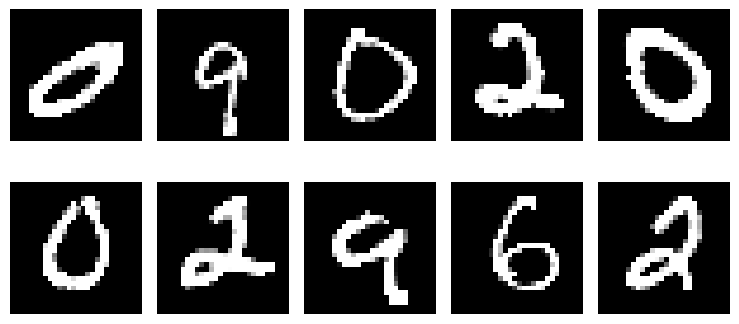

Epoch   1/50 | Train Loss: 0.4768 | Val Loss: 0.2296
Epoch   6/50 | Train Loss: 0.1261 | Val Loss: 0.1382
Epoch  11/50 | Train Loss: 0.0914 | Val Loss: 0.1219
Epoch  16/50 | Train Loss: 0.0695 | Val Loss: 0.1218
Epoch  21/50 | Train Loss: 0.0596 | Val Loss: 0.1156
Early stopping triggered.

Test Accuracy: 97.40%


' \nnum layers and neurons per layer\nshuffling before each epoch\nbatch_size for training per batchs\ndropout\nweight_decay\noptmizers_type  \nlearning rate\nearly_stopping\n'

In [ ]:
# ===============================
# Deep Neural Network from Scratch adding hyperparameters
# Dataset: MNIST (Multiclass Classification)
# ===============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# =======================================
# 1. Load and Preprocess Data
# =======================================
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

show_images(X_train)


# =======================================
# 2. Activations
# =======================================
def sigmoid(x, is_derivative=False):
    if is_derivative:
        return np.exp(-x) / ((1 + np.exp(-x)) ** 2)
    return 1 / (1 + np.exp(-x))

def tanh(x, is_derivative=False):
    if is_derivative:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

def relu(x, is_derivative=False):
    if is_derivative:
        return (x > 0).astype(float)
    return np.maximum(0, x)

def leaky_relu(x, is_derivative=False, alpha=0.01):
    if is_derivative:
        x = np.where(x < 0, alpha, 1)
        return x
    return np.maximum(alpha * x, x)

def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=0, keepdims=True)


# =======================================
# 3. Loss Functions
# =======================================
def mse_loss(Y, Y_pred):
    m = Y.shape[0]
    return np.sum((Y - Y_pred.T) ** 2) / (2 * m)

def cross_entropy_loss(Y, Y_pred, eps=1e-9):
    m = Y.shape[0]
    return -np.sum(Y * np.log(Y_pred.T + eps)) / m


# =======================================
# 4. Initialization
# =======================================
def initialize_parameters(layer_dims):
    np.random.seed(42)
    params = {}
    for i in range(1, len(layer_dims)):
        params[f"W{i}"] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * np.sqrt(1. / layer_dims[i - 1])
        params[f"b{i}"] = np.zeros((layer_dims[i], 1))
    return params


# =======================================
# 5. Forward
# =======================================
def forward_propagation(X, params, activations, dropout_rates=None, training=True):
    cache = {"A0": X.T}
    L = len(activations)
    dropout_masks = {}

    for i in range(1, L + 1):
        W, b = params[f"W{i}"], params[f"b{i}"]
        A_prev = cache[f"A{i-1}"]
        Z = np.dot(W, A_prev) + b

        if activations[i-1] == "sigmoid": A = sigmoid(Z)
        elif activations[i-1] == "relu": A = relu(Z)
        elif activations[i-1] == "tanh": A = tanh(Z)
        elif activations[i-1] == "leaky_relu": A = leaky_relu(Z)
        elif activations[i-1] == "softmax": A = softmax(Z)
        else: raise ValueError(f"Unsupported activation: {activations[i-1]}")

        # Dropout
        if training and dropout_rates and i <= len(dropout_rates):
            rate = dropout_rates[i - 1]
            mask = (np.random.rand(*A.shape) > rate).astype(float)
            A *= mask
            A /= (1 - rate)
            dropout_masks[f"M{i}"] = mask

        cache[f"Z{i}"], cache[f"A{i}"] = Z, A

    return cache[f"A{L}"], cache, dropout_masks


# =======================================
# 6. Backpropagation
# =======================================
def backward_propagation(Y, params, cache, activations, dropout_masks=None, dropout_rates=None, weight_decay=0.0):
    grads = {}
    m = Y.shape[0]
    L = len(activations)
    Y = Y.T
    dZ = cache[f"A{L}"] - Y

    for i in reversed(range(1, L + 1)):
        A_prev = cache[f"A{i-1}"]
        W = params[f"W{i}"]

        grads[f"dW{i}"] = (1 / m) * np.dot(dZ, A_prev.T) + weight_decay * W
        grads[f"db{i}"] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        grads = {k: np.clip(v, -1, 1) for k, v in grads.items()}

        if i > 1:
            Z_prev = cache[f"Z{i-1}"]
            dA_prev = np.dot(W.T, dZ)

            if dropout_masks and i - 1 in [int(k[1:]) for k in dropout_masks.keys()]:
                mask = dropout_masks[f"M{i-1}"]
                dA_prev *= mask
                dA_prev /= (1 - dropout_rates[i - 2])

            if activations[i - 2] == "sigmoid":
                dZ = dA_prev * sigmoid(Z_prev, is_derivative=True)
            elif activations[i - 2] == "relu":
                dZ = dA_prev * relu(Z_prev, is_derivative=True)
            elif activations[i - 2] == "tanh":
                dZ = dA_prev * tanh(Z_prev, is_derivative=True)
            elif activations[i - 2] == "leaky_relu":
                dZ = dA_prev * leaky_relu(Z_prev, is_derivative=True)

    return grads


# =======================================
# 7. Optimizers
# =======================================
'''
    Stochatic Gradient Descent (SGD):
    θ^(t+1) <- θ^t - η∇L(y, ŷ)

    Momentum:
    v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
    θ^(t+1) <- θ^t - ηv^(t+1)
'''
def update_parameters(params, grads, lr, optimizer_type, velocity=None, beta=0.9):
    if optimizer_type == "sgd":
        for i in range(1, len(params)//2 + 1):
            params[f"W{i}"] -= lr * grads[f"dW{i}"]
            params[f"b{i}"] -= lr * grads[f"db{i}"]

    elif optimizer_type == "momentum":
        if velocity is None:
            velocity = {k: np.zeros_like(v) for k, v in params.items()}

        for i in range(1, len(params)//2 + 1):
            velocity[f"W{i}"] = beta * velocity[f"W{i}"] + (1 - beta) * grads[f"dW{i}"]
            velocity[f"b{i}"] = beta * velocity[f"b{i}"] + (1 - beta) * grads[f"db{i}"]
            params[f"W{i}"] -= lr * velocity[f"W{i}"]
            params[f"b{i}"] -= lr * velocity[f"b{i}"]

    return params, velocity


# =======================================
# 8. Training Loop
# =======================================
def train_neural_network(
    X, 
    Y, 
    hidden_layers=[128, 64], 
    lr=0.01, 
    epochs=50,
    batch_size=64,
    activations=None, 
    loss_function="cross_entropy",
    optimizer_type="momentum",
    dropout_rates=None, 
    weight_decay=1e-4, 
    early_stopping=True, 
    patience=5, 
    print_every=100
):
    input_dim, output_dim = X.shape[1], Y.shape[1]
    layer_dims = [input_dim] + hidden_layers + [output_dim]
    if activations is None:
        activations = ["relu"] * len(hidden_layers) + ["softmax"]

    params = initialize_parameters(layer_dims)
    velocity = None
    best_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        # Shuffle
        perm = np.random.permutation(X.shape[0])
        X_shuffled, Y_shuffled = X[perm], Y[perm]

        # Mini-batch iteration
        if batch_size is None:
            batches = [(X_shuffled, Y_shuffled)]
        else:
            batches = [
                (X_shuffled[i:i+batch_size], Y_shuffled[i:i+batch_size])
                for i in range(0, X.shape[0], batch_size)
            ]

        epoch_loss = 0.0
        for X_batch, Y_batch in batches:
            A_out, cache, dropout_masks = forward_propagation(X_batch, params, activations, dropout_rates)
            loss = cross_entropy_loss(Y_batch, A_out)
            grads = backward_propagation(Y_batch, params, cache, activations, dropout_masks, dropout_rates, weight_decay)
            params, velocity = update_parameters(params, grads, lr, optimizer_type, velocity)
            epoch_loss += loss

        # Validation loss
        A_val, _, _ = forward_propagation(X_test, params, activations, training=False)
        val_loss = cross_entropy_loss(y_test, A_val) if loss_function == "cross_entropy" else mse_loss(y_test, A_val)
        loss = epoch_loss / len(batches)

        if epoch % print_every == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")


        # Early stopping
        if early_stopping:
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_params = params.copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    params = best_params
                    break

    return params


# =======================================
# 9. Prediction & Evaluation
# =======================================
def predict(X, params, activations):
    A_out, _, _ = forward_propagation(X, params, activations, training=False)
    return np.argmax(A_out, axis=0)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100


# =======================================
# 10. Run Training and Evaluate
# =======================================
params = train_neural_network(
    X_train,
    y_train,
    hidden_layers=[128, 64], 
    lr=0.05, 
    epochs=50,
    batch_size=64,
    activations=["relu", "relu", "softmax"],
    loss_function="cross_entropy",
    optimizer_type="momentum",
    dropout_rates=[0.2, 0.2],
    weight_decay=1e-4, 
    early_stopping=True, 
    patience=5, 
    print_every=5
)

# Evaluate
y_pred = predict(X_test, params, ["relu", "relu", "softmax"])
y_true = np.argmax(y_test, axis=1)
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc:.2f}%")